# Import Libraries

In [1]:
# Reading Data
import pandas_datareader as pdr

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

# Data Manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Get the Pandemic Timelines

In [2]:
# Read the timelines from the CSV file
timelines = pd.read_csv('pandemics_timelines.csv').dropna()
for col in timelines.columns[1:]:
    timelines[col] = pd.to_datetime(timelines[col])
timelines 

,pandemic_name,first_case,who_emergency,pandemic_declaration,last_date
0,covid19,2019-11-17,2020-01-30,2020-03-11,2020-07-31
1,SARS,2002-11-16,2003-03-26,2003-03-26,2003-07-05
2,Swine Flu,2009-04-15,2009-04-25,2009-06-11,2010-08-11
3,Hong Kong Flu,1968-07-01,1968-09-30,1968-09-30,1970-12-31
4,Asian Flu,1957-02-28,1957-06-30,1957-06-30,1958-12-31
5,EBOLA,2013-12-01,2014-08-08,2014-08-08,2016-01-14
6,WWII,1939-09-01,1939-09-01,1939-09-01,1945-09-02


# Get the Data

In [3]:
def get_data(tl):    
    inst_list = ['^GSPC', 'CL=F','GC=F', 'TLT']
    data = pd.DataFrame()
    for inst in inst_list:
        try:
            data[inst] = pdr.get_data_yahoo(inst, tl.first_case.iloc[0]-timedelta(days=30), 
                                        tl.last_date.iloc[0]+timedelta(days=365))['Adj Close']    
        except Exception as e:
            print('No data available for ',inst, e)

    return data

In [4]:
# Get data during covid19 pandemic
covid_timelines = timelines.loc[timelines.pandemic_name=='covid19']
data= get_data(covid_timelines)
data.head()

,^GSPC,CL=F,GC=F,TLT
Date,,,,
2019-10-17,2997.949951,53.930000,1492.300049,138.241058
2019-10-18,2986.199951,53.779999,1488.199951,138.241058
2019-10-21,3006.719971,53.310001,1482.400024,137.201126
2019-10-22,2995.989990,54.160000,1481.699951,138.003357
2019-10-23,3004.520020,55.970001,1489.900024,138.141998


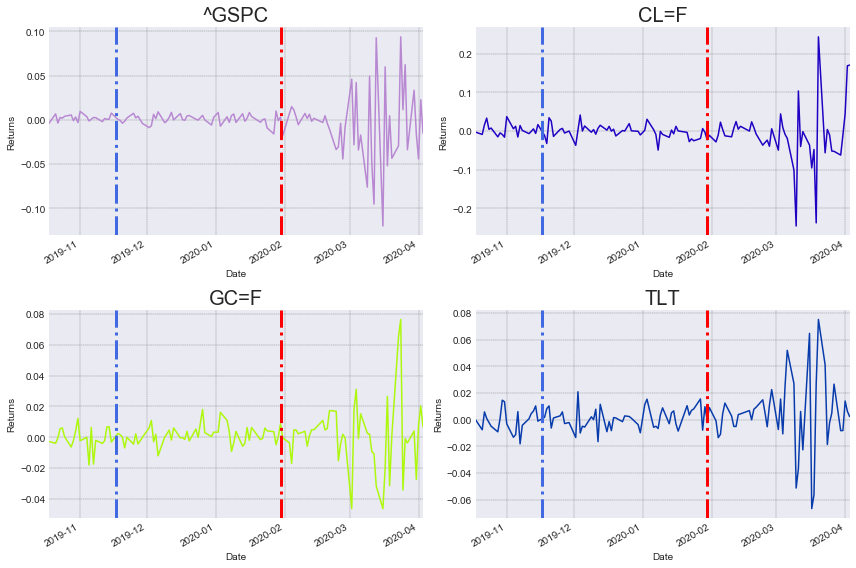

In [5]:
def plot_daily_pc(data, tl):
    data_pc = data.pct_change().dropna()
    fig = plt.figure(figsize=(12, 8))
    i = 0
    for col in data_pc.columns:
        # Add the subplot
        sub = fig.add_subplot(2, 2, i+1)
        i = i+1
        # Set title
        sub.set_title(col, fontsize=20)
        # Plot
        r = random.random()
        b = random.random()
        g = random.random()
        data_pc[col].plot(color=(r, g, b))
        sub.set_ylabel('Returns')
        sub.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
        sub.axvline(x=tl.first_case.iloc[0], color='RoyalBlue',
                    linestyle='dashdot', linewidth=3)
        sub.axvline(x=tl.who_emergency.iloc[0], color='Red',
                    linestyle='dashdot', linewidth=3)

    plt.tight_layout()
    plt.show()
    
plot_daily_pc(data, covid_timelines)

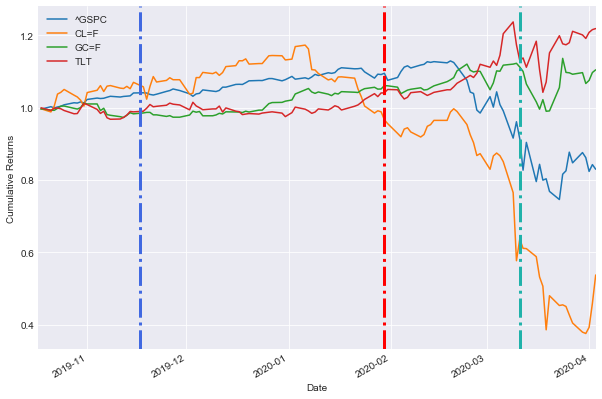

In [6]:
def plot_cumulative_returns(data,tl):
    data_cum_ret = (data.pct_change()+1).cumprod()
    data_cum_ret.plot(figsize=(10,7),grid=True)
    plt.legend(loc='best')
    plt.ylabel('Cumulative Returns')
    plt.axvline(x=tl.first_case.iloc[0],color='RoyalBlue',linestyle='dashdot',linewidth=3)
    plt.axvline(x=tl.who_emergency.iloc[0],color='Red',linestyle='dashdot',linewidth=3)
    plt.axvline(x=tl.pandemic_declaration.iloc[0],color='LightSeaGreen',linestyle='dashdot',linewidth=3)
    plt.axvspan(tl.last_date.iloc[0], tl.last_date.iloc[0]+timedelta(days=365),color='dodgerblue', alpha=0.2)
    plt.show()
    
plot_cumulative_returns(data, covid_timelines)

In [7]:
def calc_drawdown(data, tl):
    data_cum_ret = (data.pct_change()+1).cumprod()
    cum_rets = data_cum_ret.loc[tl.first_case.iloc[0]:tl.last_date.iloc[0]]
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown


def plot_drawdown(drawdown, tl):
    fig = plt.figure(figsize=(12, 8))
    i = 0
    for col in drawdown.columns:
        # Add the subplot
        sub = fig.add_subplot(2, 2, i+1)
        i = i+1
        # Set title
        sub.set_title(col, fontsize=20)
        # Plot

        drawdown[col].plot(color='r')
        sub.set_ylabel('Returns')
        sub.fill_between(drawdown.index, drawdown[col], color='red')
        sub.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
        sub.axvline(x=tl.first_case.iloc[0], color='RoyalBlue',
                    linestyle='dashdot', linewidth=3)
        sub.axvline(x=tl.who_emergency.iloc[0], color='red',
                    linestyle='dashdot', linewidth=3)

    plt.tight_layout()
    plt.show()

^GSPC   -33.924960
CL=F    -67.946893
GC=F    -11.804018
TLT     -15.727707
dtype: float64


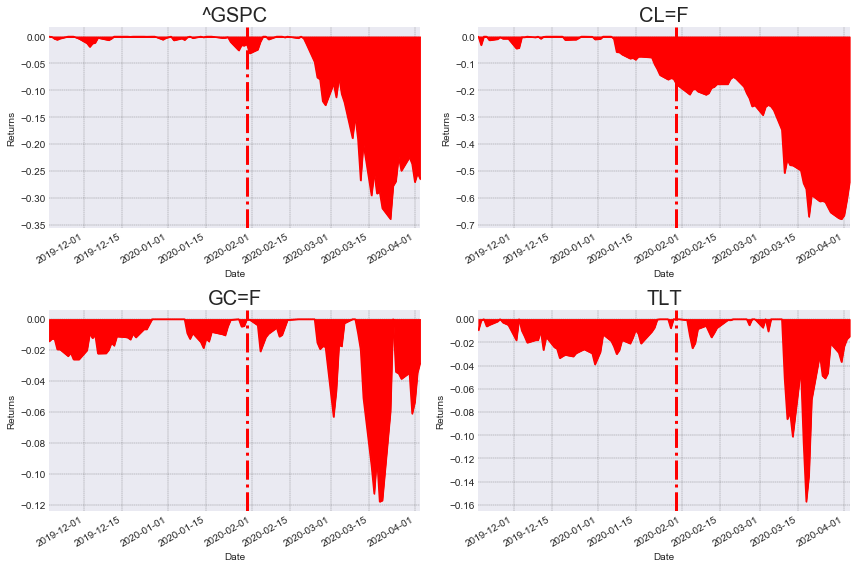

In [8]:
#data.columns = ['SP500','Crude Oil', 'Gold', 'TLT']
drawdown = calc_drawdown(data,covid_timelines)
# Find the maximum drawdowns
print(drawdown.min()*100)
#plt.style.use('seaborn-darkgrid')
plot_drawdown(drawdown,covid_timelines)

Correlation           ^GSPC      CL=F      GC=F       TLT
^GSPC  1.000000 -0.100655  0.091451 -0.502007
CL=F  -0.100655  1.000000  0.159662  0.201441
GC=F   0.091451  0.159662  1.000000  0.072155
TLT   -0.502007  0.201441  0.072155  1.000000


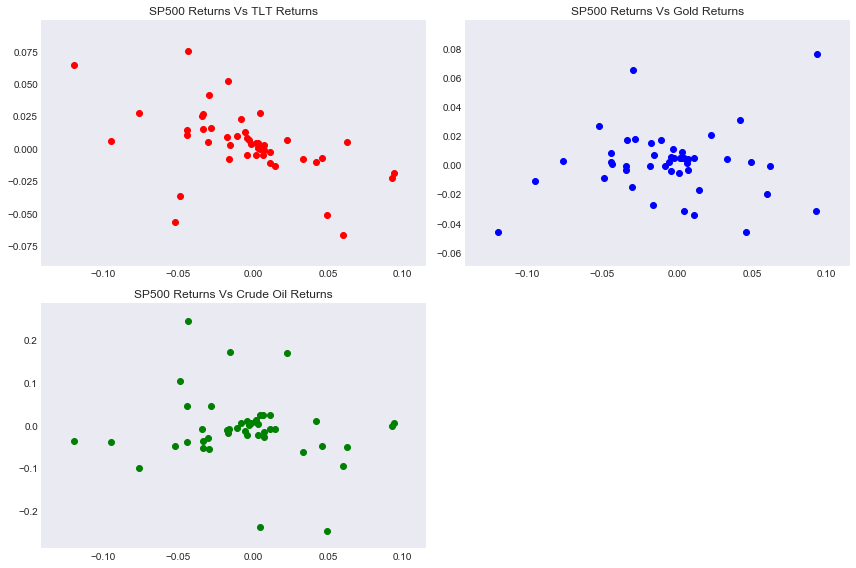

In [9]:
def plot_scatter(data, tl):
    data_pc = data.pct_change().dropna()
    temp = data_pc.loc[tl.who_emergency.iloc[0]:tl.last_date.iloc[0]]

    fig = plt.figure(figsize=(12, 8))

    sub = fig.add_subplot(2, 2, 1)
    sub.scatter(temp['^GSPC'],temp['TLT'],color='red')
    sub.set_title('SP500 Returns Vs TLT Returns')
    sub.grid()

    sub = fig.add_subplot(2, 2, 2)
    sub.scatter(temp['^GSPC'],temp['GC=F'],color='blue')
    sub.set_title('SP500 Returns Vs Gold Returns')
    sub.grid()

    sub = fig.add_subplot(2, 2, 3)
    sub.scatter(temp['^GSPC'],temp['CL=F'],color='green')
    sub.set_title('SP500 Returns Vs Crude Oil Returns')
    sub.grid()
    
    # Correlation
    sum_corr = data_pc[data_pc.columns].corr()
    print('Correlation',sum_corr)


    plt.tight_layout()
    plt.show()
    
plot_scatter(data,covid_timelines)    

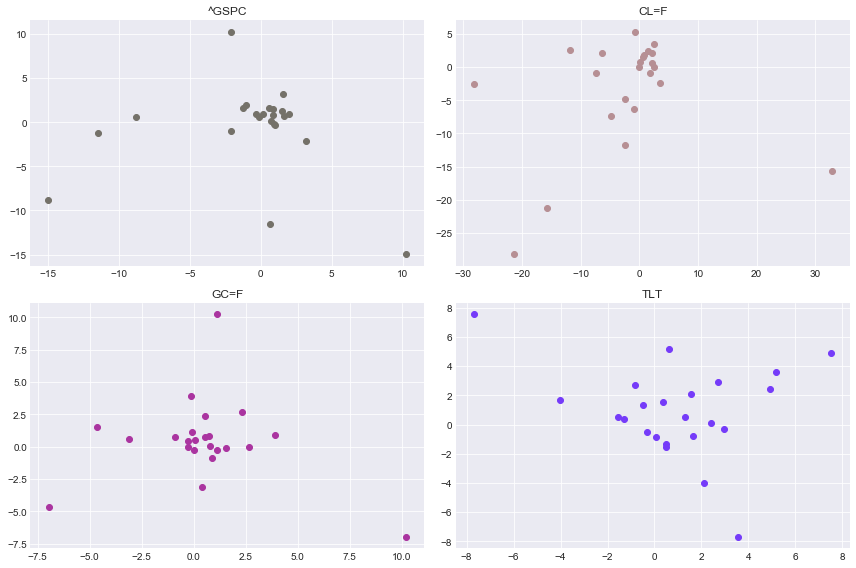

In [10]:
def plot_auto_correlation(data, tl):
    data_pc = data.resample('W').ffill().pct_change()*100
    fig = plt.figure(figsize=(12, 8))
    i=1
    for col in data_pc.columns:        
        sub = fig.add_subplot(2, 2, i)
        i=i+1
        r = random.random()
        b = random.random()
        g = random.random()        
        sub.scatter(data_pc.loc[:,col],data_pc.shift(1).loc[:,col],color=(r,g,b))
        sub.set_title(col)
    plt.tight_layout()
    plt.show()
    
plot_auto_correlation(data,covid_timelines)    

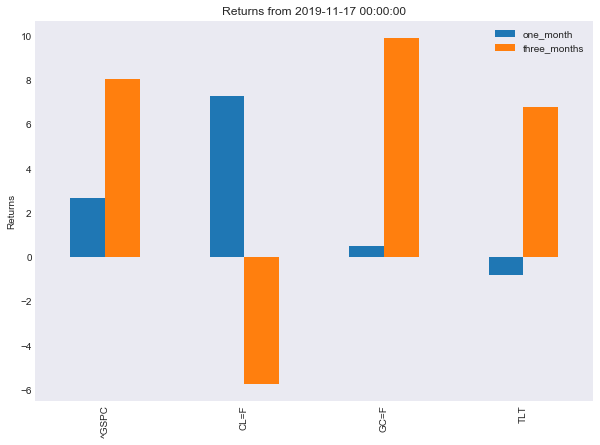

In [11]:
def calc_returns(data,first_date):
    returns = pd.DataFrame(index=data.columns)
    data = data.loc[first_date:]
    try:
        returns['one_month'] = (data.iloc[22]/data.iloc[0]-1)*100
        returns['three_months'] = (data.iloc[63]/data.iloc[0]-1)*100
        returns['six_months'] = (data.iloc[126]/data.iloc[0]-1)*100
        returns['one_year'] = (data.iloc[252]/data.iloc[0]-1)*100        
    except:
        pass
    returns.plot.bar(figsize=(10,7))
    plt.ylabel('Returns')
    plt.title('Returns from '+str(first_date))
    plt.grid()
    plt.show()
    return returns

first_case_date = covid_timelines.first_case.iloc[0]
r = calc_returns(data,first_case_date)

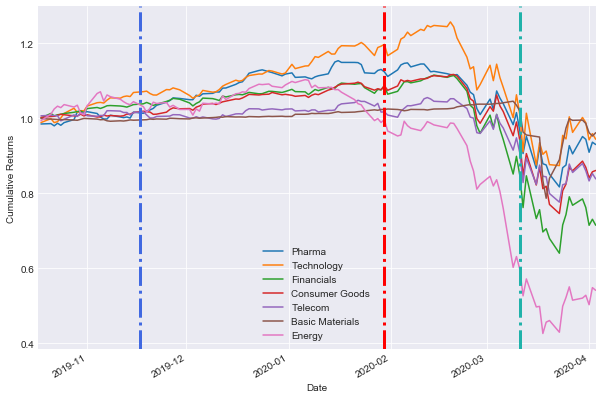

In [12]:
def plot_sector(tl):
    sector_list = ['IHE', 'IYW', 'IYF', 'IYK', 'IYZ','ITM', 'IYE']

    columns = ['Pharma', 'Technology', 'Financials', 'Consumer Goods',
               'Telecom', 'Basic Materials', 'Energy']

    sector_data = pd.DataFrame()
    for inst in sector_list:
        try:
            sector_data[inst] = pdr.get_data_yahoo(inst, tl.first_case.iloc[0]-timedelta(days=30), 
                                        tl.last_date.iloc[0]+timedelta(days=365))['Adj Close']    
        except:
            pass

    sector_data.columns = columns
    plot_cumulative_returns(sector_data, tl)
plot_sector(covid_timelines)    

In [13]:
def plot_analytics(data, timelines):
    plot_daily_pc(data, timelines)
    plot_cumulative_returns(data, timelines)
    plot_drawdown(drawdown,timelines)    
    first_case_date = timelines.who_emergency.iloc[0]
    return calc_returns(data,first_case_date)

# Get Timelines

In [14]:
timelines = pd.read_csv('pandemics_timelines.csv').dropna()
for col in timelines.columns[1:]:
    timelines[col] = pd.to_datetime(timelines[col])
timelines    

,pandemic_name,first_case,who_emergency,pandemic_declaration,last_date
0,covid19,2019-11-17,2020-01-30,2020-03-11,2020-07-31
1,SARS,2002-11-16,2003-03-26,2003-03-26,2003-07-05
2,Swine Flu,2009-04-15,2009-04-25,2009-06-11,2010-08-11
3,Hong Kong Flu,1968-07-01,1968-09-30,1968-09-30,1970-12-31
4,Asian Flu,1957-02-28,1957-06-30,1957-06-30,1958-12-31
5,EBOLA,2013-12-01,2014-08-08,2014-08-08,2016-01-14
6,WWII,1939-09-01,1939-09-01,1939-09-01,1945-09-02


# Past Pandemics

---------------------------------
Swine Flu
---------------------------------
---------------------------------
                 ^GSPC       CL=F        GC=F        TLT
Date                                                    
2009-03-16  753.890015  47.349998  921.599976  73.121437
2009-03-17  778.119995  49.160000  916.400024  72.723694
2009-03-18  794.349976  48.139999  888.700012  75.479034
2009-03-19  784.039978  51.610001  958.299988  75.573044
2009-03-20  768.539978  51.060001  955.799988  75.153580
---------------------------------
Drawdowns ^GSPC   -15.994677
CL=F    -21.683550
GC=F    -13.569909
TLT     -14.379870
dtype: float64
---------------------------------


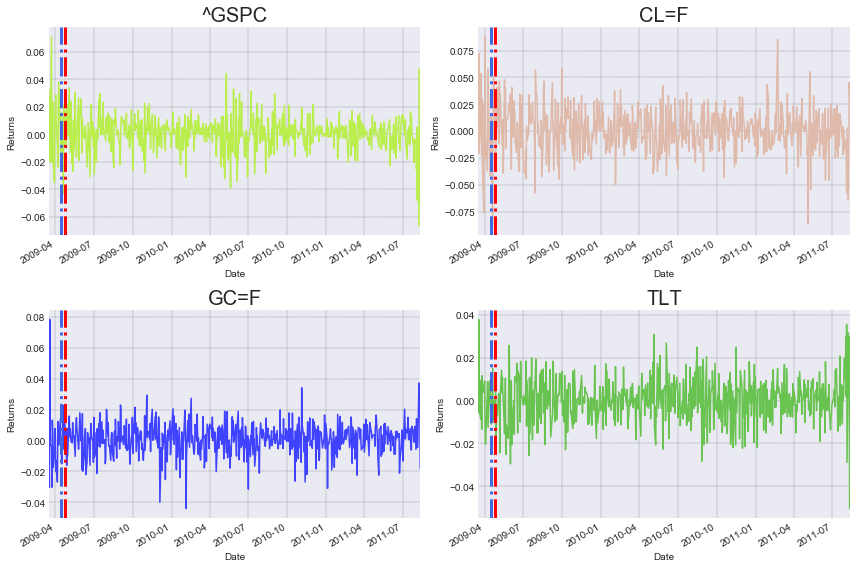

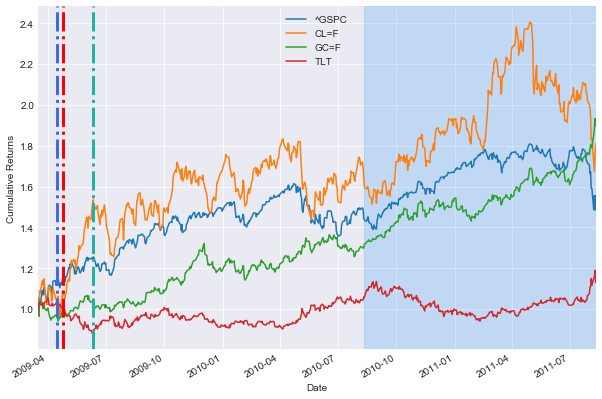

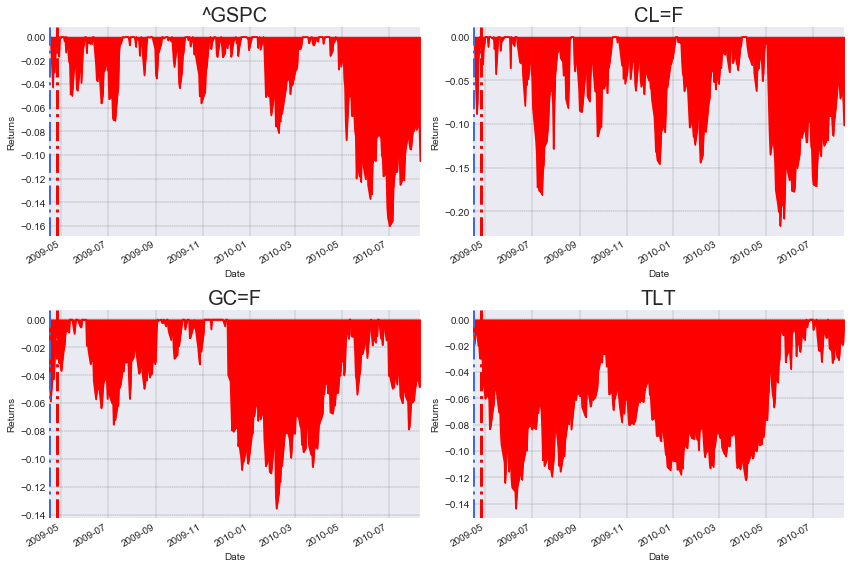

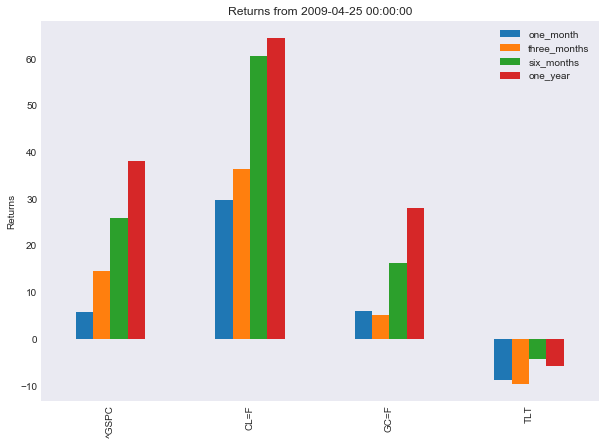

       one_month  three_months  six_months   one_year
^GSPC   5.751537     14.538604   25.899402  38.040367
CL=F   29.796575     36.378137   60.550461  64.419632
GC=F    5.962087      5.058404   16.332372  28.025118
TLT    -8.832858     -9.641926   -4.172855  -5.774440
Correlation           ^GSPC      CL=F      GC=F       TLT
^GSPC  1.000000  0.522562  0.090348 -0.455661
CL=F   0.522562  1.000000  0.334871 -0.292564
GC=F   0.090348  0.334871  1.000000  0.015626
TLT   -0.455661 -0.292564  0.015626  1.000000


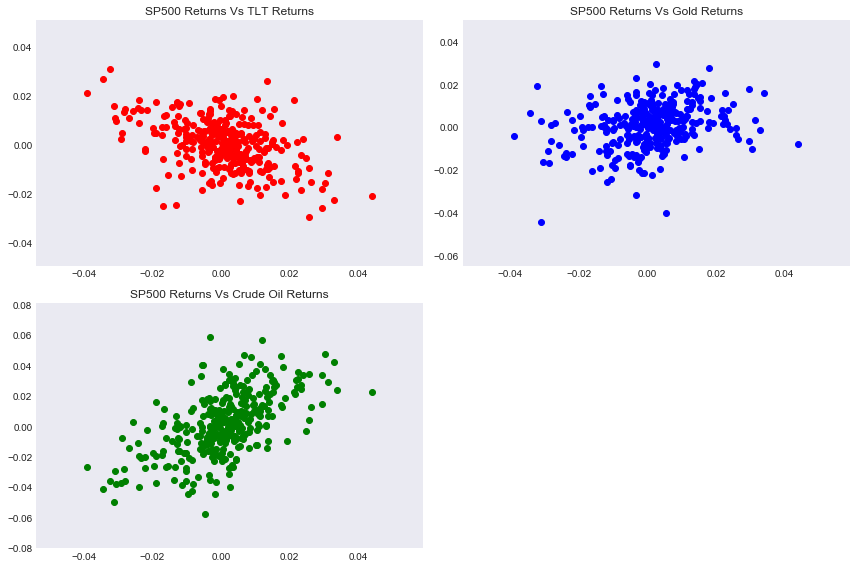

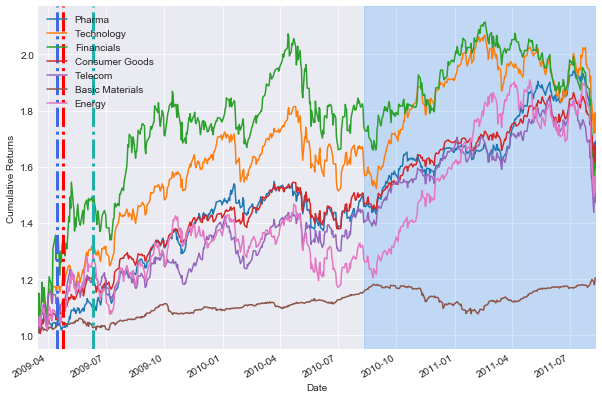

In [16]:
p = 'Swine Flu'
print("---------------------------------")
print(p)
tl = timelines[timelines.pandemic_name == p]

print("---------------------------------")
data = get_data(tl)
print("---------------------------------")
print(data.head())

print("---------------------------------")
drawdown = calc_drawdown(data,tl)
print('Drawdowns', drawdown.min()*100)

print("---------------------------------")
print(plot_analytics(data, tl))
try:
    if data.shape[1] > 1:
        plot_scatter(data,tl)
    plot_sector(tl)
except Exception as e:
    pass